[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp551-notebooks/blob/master/KNN.ipynb)

# K-Nearest Neighbours 
Our goal is to implement a K-NN classifier and apply it to classify the Iris dataset.

##Data processing and visualization

We always have this set of imports at the beginning of our notebooks and set the random seed.

In [52]:
import numpy as np
import time
#the output of plotting commands is displayed inline within frontends
%matplotlib inline                                  
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace         #for debugging 

#it is important to set the seed for reproducibility as it initializes the random number generator
np.random.seed(1234)

We conveniently load the dataset from the sklearn collection of datasets. In this notebook we use the Iris dataset.

In [53]:
from sklearn import datasets
#to read more about load_iris() function refer to: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html
dataset = datasets.load_iris()
# print(dir(dataset)) # check components of the loaded dataset
# uncomment this if you want to see the description of the dataset 
# print(dataset.DESCR) # or print(dataset['DESCR'])
# uncomment to see the details about the dataset class
# help(dataset)

We create the input matrix $X \in \mathbb{R}^{N \times D}$ and the output vector $y \in \{1,\ldots,C\}^N$.
Let's only use `sepal length` and `sepal width` for classification, since we know they have high correlation with the class label. We then randomly split the data into train and test and visualize the data.

instances (N) 	 150 
 features (D) 	 2 
 classes (C) 	 3


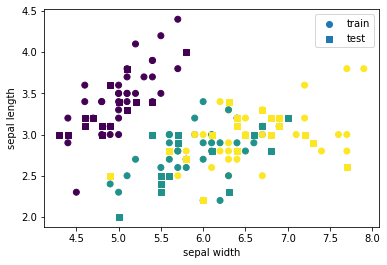

In [54]:
# dataset['data'] and dataset['target'] are both numpy arrays
# dataset['data'] is (150, 4), and dataset['target'] is (150,)
x, y = dataset['data'][:,:2], dataset['target'] #slices the first two columns or features from the data

#print the feature shape and classes of dataset 
(N,D), C = x.shape, np.max(y)+1
print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')

inds = np.random.permutation(N)      #generates an indices array from 0 to N-1 and permutes it 

#split the dataset into train and test
x_train, y_train = x[inds[:100]], y[inds[:100]]
x_test, y_test = x[inds[100:]], y[inds[100:]]

#visualization of the data
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', label='train')
plt.scatter(x_test[:,0], x_test[:,1], c=y_test, marker='s', label='test')
plt.legend()
plt.ylabel('sepal length')
plt.xlabel('sepal width')
# plt.show()
plt.savefig('iris.png', dpi=300)

numpy Broadcast demonstration

In [55]:
# broadcast: if same dim, then check the 1's (every entry either has the same entry, or one of them is 1)
# eg (3,4,1) is compatible with (3,4,5), 
# (1,5,1) is compatible with (3,5,2)
# if not the same size, then we can preppend 1's to make them the same dim, and then check the 1's.
# eg (3,2,4) is compatible with (2, 4), 
#    (2,3) is compatible with (3,)
# eg, (3,5,6,2) is compatible with (6,1)

print("case 1:")
# now let's imagine (2, 1) * (2, 3)
a = np.array([[3], [2]])
b = np.array([[3,4,5], [2,5,1]])
# effective a is
# [[3, 3, 3],
#  [2, 2, 2]]
# b is just 
# [[3, 4, 5],
#  [2, 5, 1]]
print(f"a + b is \n{a + b}")

print("\ncase 2: ")
# now let's imagine (2, 1) * (1, 3)
a = np.array([[3], [2]])
b = np.array([[3,4,5]])
# effective a is
# [[3, 3, 3],
#  [2, 2, 2]]
# effective b is
# [[3, 4, 5],
#  [3, 4, 5]]
# so a * b is
print(f"a * b is \n{a * b}")
# same with any other operations

# so (1,2,4) * (3,1,4) is (3,2,4)

case 1:
a + b is 
[[6 7 8]
 [4 7 3]]

case 2: 
a * b is 
[[ 9 12 15]
 [ 6  8 10]]


A demonstration on the usage of axis parameter on numpy aggregation functions (like np.var(), np.std(), np.mean(), np.sum() etc)

In [56]:
a = np.array([
    [1,2,5], 
    [5,2,3]
])
print(f"original shape is {a.shape}")
row_sum = np.sum(a, axis = 1)
print("we squash the 1st axis")
print(row_sum, row_sum.shape)

a = np.array([
    [[1,2,3,5], [3,5,2,6]],
    [[5,6,2,2], [3,0,1,2]],
    [[6,2,3,1], [3,5,2,6]]
])
print(f"original shape is {a.shape}")
the_sum = np.sum(a, axis = (1,2))
print("we squash the 1st and 2nd axis")
print(the_sum, the_sum.shape)

original shape is (2, 3)
we squash the 1st axis
[ 8 10] (2,)
original shape is (3, 2, 4)
we squash the 1st and 2nd axis
[27 21 28] (3,)


Effectiveness of using numpy functions versus for loops

In [57]:
N_train = 1000
N_test = 100
D = 100
X_train_temp = np.random.randn(N_train, D)
X_test_temp = np.random.randn(N_test, D)
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))


# use np operation (broadcast)
t_np = time.time()
distance_np = euclidean(X_train_temp[None, :, :], X_test_temp[:, None, :])
print(f"t_np is {time.time()-t_np} s")

# fetch each pair of points and calculate distance by the np operation
t_small_for = time.time()
distance_small_for = np.zeros((N_test, N_train))
for i in range(N_test):
    for j in range(N_train):
        distance_small_for[i][j] = euclidean(X_train_temp[j], X_test_temp[i])
print(f"t_small_for is {time.time() - t_small_for} s")

# fetch each pair of points, and use built-in sum with directly fetched values
t_fancy_sum_for = time.time()
distance_fancy_sum_for = np.zeros((N_test, N_train))
for i in range(N_test):
    for j in range(N_train):
        distance_fancy_sum_for[i][j] = np.sqrt(sum((k1-k2)**2 for k1, k2 in zip(X_train_temp[j], X_test_temp[i])))
print(f"t_fancy_sum_for is {time.time() - t_fancy_sum_for} s")

# fetch each pair of points, and use built-in sum
t_sum_for = time.time()
distance_sum_for = np.zeros((N_test, N_train))
for i in range(N_test):
    for j in range(N_train):
        distance_sum_for[i][j] = np.sqrt(sum((X_train_temp[j][k]-X_test_temp[i][k])**2 for k in range(D)))
print(f"t_sum_for is {time.time() - t_sum_for} s")

# fetch each pair of points, and use for loop.
t_big_for = time.time()
distance_big_for = np.zeros((N_test, N_train))
for i in range(N_test):
    for j in range(N_train):
        the_sum = 0
        for k in range(D):
            the_sum += (X_train_temp[j][k]-X_test_temp[i][k])**2
        distance_big_for[i][j] = np.sqrt(the_sum)
print(f"t_big_for is {time.time() - t_big_for} s")
print(f"The answers are the same: {np.allclose(distance_np, distance_small_for) and np.allclose(distance_small_for, distance_sum_for) and np.allclose(distance_sum_for, distance_fancy_sum_for) and np.allclose(distance_fancy_sum_for, distance_big_for)}")

t_np is 0.037036895751953125 s
t_small_for is 1.1161723136901855 s
t_fancy_sum_for is 5.492984294891357 s
t_sum_for is 9.582010984420776 s
t_big_for is 10.374083518981934 s
The answers are the same: True


## The `KNN` class
We implement our models as python classes. Two class methods that we usually need to implement are `fit` and `predict`; which respectively perform training by fitting the data, and making prediction on new data. In the `__init__` function, we initialize our model, usually this includes an assignment to *hyper-parameters*.

In [58]:
#define the metric we will use to measure similarity
#if the input shapes are [1,N1,F] and [N2,1,F] then output shape is [N2,N1]
#as numpy supports broadcasting with arithmetic operations
#for more on numpy broadcasting refer to: https://numpy.org/doc/stable/user/basics.broadcasting.html   
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)

class KNN:

    def __init__(self, K=1, dist_fn= euclidean):
        self.dist_fn = dist_fn
        self.K = K
        return
    
    def fit(self, x, y):
        ''' Store the training data using this method as it is a lazy learner'''
        self.x = x
        self.y = y
        self.C = np.max(y) + 1
        return self
    
    def predict(self, x_test):
        ''' Makes a prediction using the stored training data and the test data given as argument'''
        num_test = x_test.shape[0]
        # calculate distance between the training & test samples and returns an array of shape [num_test, num_train]
        # self.x is in shape (100, 2), x_test is in shape (50, 2)
        # self.x[None, :, :] is in shape (1, 100, 2), and x_test[:,None,:] is in shape (50, 1, 2)
        # result: (x_test.shape[0], self.x.shape[0])
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])
        #ith-row of knns stores the indices of k closest training samples to the ith-test sample 
        knns = np.zeros((num_test, self.K), dtype=int)
        #ith-row of y_prob has the probability distribution over C classes
        y_prob = np.zeros((num_test, self.C))
        for i in range(num_test):
            # print(i)
            knns[i,:] = np.argsort(distances[i])[:self.K]
            # print(knns[i,:])
            y_prob[i,:] = np.bincount(self.y[knns[i,:]], minlength=self.C) #counts the number of instances of each class in the K-closest training samples
        #y_prob /= np.sum(y_prob, axis=-1, keepdims=True)
        #simply divide by K to get a probability distribution
        y_prob /= self.K
        return y_prob, knns

We next `fit` the model(for KNN no learning occurs in training time), and make a prediction on test set(all the computation takes place during testing). We further connect each test node to its closest nearest neighbors in the plot.

knns shape: (50, 1)
y_prob shape: (50, 3)
accuracy is 72.0.


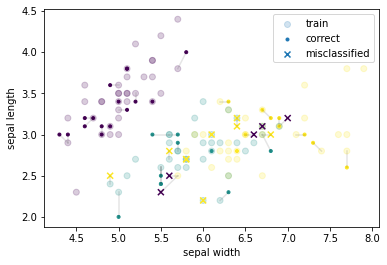

In [59]:
myK = 1

model = KNN(K=myK)

y_prob, knns = model.fit(x_train, y_train).predict(x_test)
print('knns shape:', knns.shape)
print('y_prob shape:', y_prob.shape)

#To get hard predictions by choosing the class with the maximum probability
y_pred = np.argmax(y_prob, axis=-1)
accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
print(f'accuracy is {accuracy*100:.1f}.')

#boolean array to later slice the indexes of correct and incorrect predictions
correct = y_test == y_pred
incorrect = np.logical_not(correct)

#visualization of the points
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', alpha=.2, label='train')
plt.scatter(x_test[correct,0], x_test[correct,1], marker='.', c=y_pred[correct], label='correct')
plt.scatter(x_test[incorrect,0], x_test[incorrect,1], marker='x', c=y_test[incorrect], label='misclassified')

#connect each node to k-nearest neighbours in the training set
for i in range(x_test.shape[0]):
    for k in range(model.K):
        hor = x_test[i,0], x_train[knns[i,k],0]
        ver = x_test[i,1], x_train[knns[i,k],1]
        plt.plot(hor, ver, 'k-', alpha=.1)
    
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.legend()
plt.savefig('iris_KNN'+str(myK)+'.png',dpi=300,bbox_inches='tight')
# plt.show()

Demonstration on meshgrid function

In [60]:
x0v = np.array([1,2,3])
x1v = np.array([7,8])
x0, x1 = np.meshgrid(x0v, x1v)
print(f"x0 is \n {x0}")
print(f"x1 is \n {x1}")
print(f"x0.ravel() is \n {x0.ravel()}")
print(f"x1.ravel() is \n {x1.ravel()}")
x_all = np.vstack((x0.ravel(),x1.ravel())).T

x0 is 
 [[1 2 3]
 [1 2 3]]
x1 is 
 [[7 7 7]
 [8 8 8]]
x0.ravel() is 
 [1 2 3 1 2 3]
x1.ravel() is 
 [7 7 7 8 8 8]


## Decision Boundaries
To draw the decision boundary we classify all the points on a 2D grid. The `meshgrid` function creates all the points on the grid by taking discretizations of horizontal and vertical axes.

1
accuracy: 72.0.
5
accuracy: 80.0.
15
accuracy: 76.0.


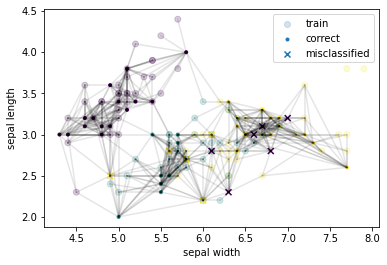

In [61]:
#we can make the grid finer by increasing the number of samples from 200 to higher value
x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)

# print(np.min(x[:,0]))
# print(np.max(x[:,0]))
# print(np.min(x[:,1]))
# print(np.max(x[:,1]))

# to features values as a mesh  
x0, x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

for k in [1, 5, 15]:
    print(k)
    model = KNN(K=k)

    y_train_prob = np.zeros((y_train.shape[0], C))
    y_train_prob[np.arange(y_train.shape[0]), y_train] = 1
    
    y_prob, knns = model.fit(x_train, y_train).predict(x_test)
    y_pred = np.argmax(y_prob,axis=-1)    
    correct = y_test == y_pred
    incorrect = np.logical_not(correct)    
    
    y_pred = np.argmax(y_prob,axis=-1)
    accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
    acc = f'accuracy: {accuracy*100:.1f}.'
    print(acc)
    

    #to get class probability of all the points in the 2D grid
    y_prob_all, _ = model.fit(x_train, y_train).predict(x_all)

    y_pred_all = np.zeros_like(y_prob_all)
    y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1    
    
    plt.clf()
    plt.scatter(x_train[:,0], x_train[:,1], c=y_train_prob, marker='o', alpha=1)
#     plt.scatter(x_test[correct,0], x_test[correct,1], marker='.', c=y_pred[correct], label='correct')
#     plt.scatter(x_test[incorrect,0], x_test[incorrect,1], marker='x', c=y_test[incorrect], label='misclassified')
#     plt.scatter(x_test[:,0], x_test[:,1], c=y_pred, marker='s')
#     plt.savefig('prediction_KNN'+str(k)+'.png', dpi=300, bbox_inches='tight')
    
    plt.scatter(x_all[:,0], x_all[:,1], c=y_pred_all, marker='.', alpha=0.01)
    plt.ylabel('sepal length')
    plt.xlabel('sepal width')
    plt.savefig('decision_boundaries_KNN'+str(k)+'.png', dpi=300, bbox_inches='tight') 
    
    
    #connect each node to k-nearest neighbours in the training set
    #visualization of the points
    plt.clf()
    
    plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', alpha=.2, label='train')
    plt.scatter(x_test[correct,0], x_test[correct,1], marker='.', c=y_pred[correct], label='correct')
    plt.scatter(x_test[incorrect,0], x_test[incorrect,1], marker='x', c=y_test[incorrect], label='misclassified')

    for i in range(x_test.shape[0]):
        for myk in range(model.K):
            hor = x_test[i,0], x_train[knns[i,myk],0]
            ver = x_test[i,1], x_train[knns[i,myk],1]
            plt.plot(hor, ver, 'k-', alpha=.1)

    plt.ylabel('sepal length')
    plt.xlabel('sepal width')
    plt.legend()
    plt.savefig('iris_KNN'+str(k)+'.png',dpi=300,bbox_inches='tight') 

We can also plot class probabilities (different values of probabilities take different colors)

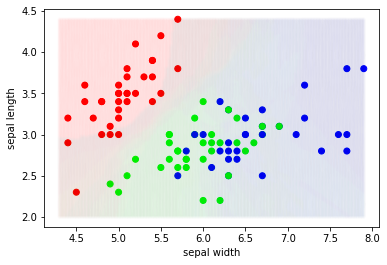

In [62]:
plt.scatter(x_train[:,0], x_train[:,1], c=y_train_prob, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=y_prob_all, marker='.', alpha=.01)
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.show()

## Choosing hyperparameter K in KNN

We further split the training data into 50% training and 50% validation to choose the hyperparmater K.

best K = 9, test accuracy = 0.76


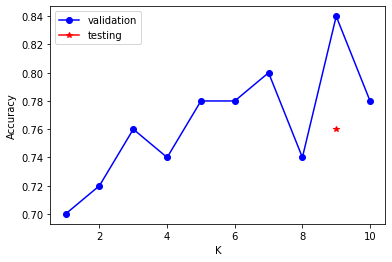

In [63]:
# further split the training data into 50% training and 50% validation
x_train_tr, y_train_tr = x_train[:50], y_train[:50]
x_train_va, y_train_va = x_train[50:], y_train[50:]

model_choices=[]
valid_acc = []

n_valid = y_train_va.shape[0]

for k in range(1,11):
    knn = KNN(K=k) # create a KNN object (OOP)
    # y_train_va_prob,_ = knn.fit(x_train, y_train).predict(x_train_va) # wrong
    y_train_va_prob,_ = knn.fit(x_train_tr, y_train_tr).predict(x_train_va) # bug fixed
    y_train_va_pred = np.argmax(y_train_va_prob,axis=-1)
    accuracy = np.sum(y_train_va_pred == y_train_va)/n_valid
    model_choices.append(k)
    valid_acc.append(accuracy)

# use the best K to predict test data
best_valid_K = model_choices[valid_acc.index(max(valid_acc))]
knn = KNN(K=best_valid_K)
y_test_prob,_ = knn.fit(x_train, y_train).predict(x_test)
y_test_pred = np.argmax(y_test_prob, axis=-1)
test_accuracy = np.sum(y_test_pred == y_test)/y_test.shape[0]
print(f'best K = {best_valid_K}, test accuracy = {test_accuracy}')

plt.plot(model_choices, valid_acc, marker='o', color='blue', label='validation')
plt.plot(best_valid_K, test_accuracy, marker='*', color='red', label='testing')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.savefig('iris_KNN_chooseK.png',dpi=300,bbox_inches='tight')

## KNN is sensitive to feature scaling

accuracy is 72.0.


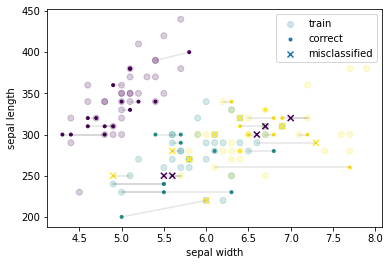

In [64]:
myK = 1

model = KNN(K=myK)

x_train_mod = x_train.copy()
x_test_mod = x_test.copy()

feature_id = 1 # feature to scale

x_train_mod[:,feature_id] = x_train_mod[:,feature_id] * 100
x_test_mod[:,feature_id] = x_test_mod[:,feature_id] * 100

y_prob, knns = model.fit(x_train_mod, y_train).predict(x_test_mod)

#To get hard predictions by choosing the class with the maximum probability
y_pred = np.argmax(y_prob,axis=-1)
accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
print(f'accuracy is {accuracy*100:.1f}.')

#boolean array to later slice the indexes of correct and incorrect predictions
correct = y_test == y_pred
incorrect = np.logical_not(correct)

#visualization of the points
plt.scatter(x_train_mod[:,0], x_train_mod[:,1], c=y_train, marker='o', alpha=.2, label='train')
plt.scatter(x_test_mod[correct,0], x_test_mod[correct,1], marker='.', c=y_pred[correct], label='correct')
plt.scatter(x_test_mod[incorrect,0], x_test_mod[incorrect,1], marker='x', c=y_test[incorrect], label='misclassified')

#connect each node to k-nearest neighbours in the training set
for i in range(x_test_mod.shape[0]):
    for k in range(model.K):
        hor = x_test_mod[i,0], x_train_mod[knns[i,k],0]
        ver = x_test_mod[i,1], x_train_mod[knns[i,k],1]
        plt.plot(hor, ver, 'k-', alpha=.1)
    
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.legend()
plt.savefig('iris_KNN'+str(myK)+'_scaledX'+str(feature_id)+'.png',dpi=300, bbox_inches='tight') 
# plt.show()

## Standardizing features

accuracy is 70.0.


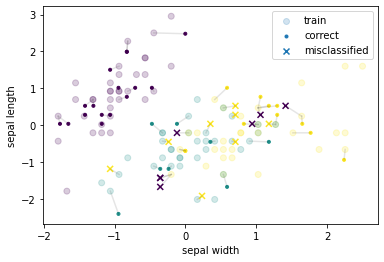

In [65]:
myK = 1

model = KNN(K=myK)

x_train_mod = x_train.copy()
x_test_mod = x_test.copy()

x_train_mod[:,0] = x_train_mod[:,0] * 100
x_test_mod[:,0] = x_test_mod[:,0] * 100

for d in range(x_train.shape[1]):
    x_train_mod[:,d] = (x_train_mod[:,d] - x_train_mod[:,d].mean())/x_train_mod[:,d].std()
    x_test_mod[:,d] = (x_test_mod[:,d] - x_test_mod[:,d].mean())/x_test_mod[:,d].std()

y_prob, knns = model.fit(x_train_mod, y_train).predict(x_test_mod)

#To get hard predictions by choosing the class with the maximum probability
y_pred = np.argmax(y_prob,axis=-1)
accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
print(f'accuracy is {accuracy*100:.1f}.')

#boolean array to later slice the indexes of correct and incorrect predictions
correct = y_test == y_pred
incorrect = np.logical_not(correct)

#visualization of the points
plt.scatter(x_train_mod[:,0], x_train_mod[:,1], c=y_train, marker='o', alpha=.2, label='train')
plt.scatter(x_test_mod[correct,0], x_test_mod[correct,1], marker='.', c=y_pred[correct], label='correct')
plt.scatter(x_test_mod[incorrect,0], x_test_mod[incorrect,1], marker='x', c=y_test[incorrect], label='misclassified')

#connect each node to k-nearest neighbours in the training set
for i in range(x_test_mod.shape[0]):
    for k in range(model.K):
        hor = x_test_mod[i,0], x_train_mod[knns[i,k],0]
        ver = x_test_mod[i,1], x_train_mod[knns[i,k],1]
        plt.plot(hor, ver, 'k-', alpha=.1)
    
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.legend()
plt.savefig('iris_KNN'+str(myK)+'_standardized.png',dpi=300, bbox_inches='tight') 
# plt.show()

## The Effect of Noise and Feature Scaling
Nearest neighbours are highly affected by the existence of noisy or irrelevant features.
Lets add noise and see how it affects the accuracy of our classifier.

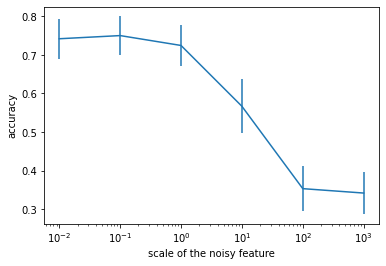

In [66]:
noise_scale = [.01, .1, 1, 10, 100, 1000]
#generate random noise
noise = np.random.randn(x.shape[0],1)
results = []
for s in noise_scale:
    #add noise as an extra feature
    x_n = np.column_stack((x, noise*s))
    results.append([])
    #repeat the experiment 100 times with different train and test split
    for r in range(100):
        #data processing and train-test split
        inds = np.random.permutation(N)
        x_train, y_train = x_n[inds[:100]], y[inds[:100]]
        x_test, y_test = x_n[inds[100:]], y[inds[100:]]
        #define model
        model = KNN(K=3)
        #prediction
        y_prob, _ = model.fit(x_train, y_train).predict(x_test)
        y_pred = np.argmax(y_prob,1)
        accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
        results[-1].append(accuracy)
results = np.array(results)
plt.errorbar(noise_scale, results.mean(1), results.std(1))
plt.xscale('log')
plt.xlabel("scale of the noisy feature")
plt.ylabel("accuracy")
# plt.show()
plt.savefig('iris_KNN3_random_feature.png',dpi=300, bbox_inches='tight') 

We see that as we increase the scale of irrelevant feature it plays a more important role when calculating distances, and so the K nearest neighbors are more decided by the noisy feature rather than the relevant ones.